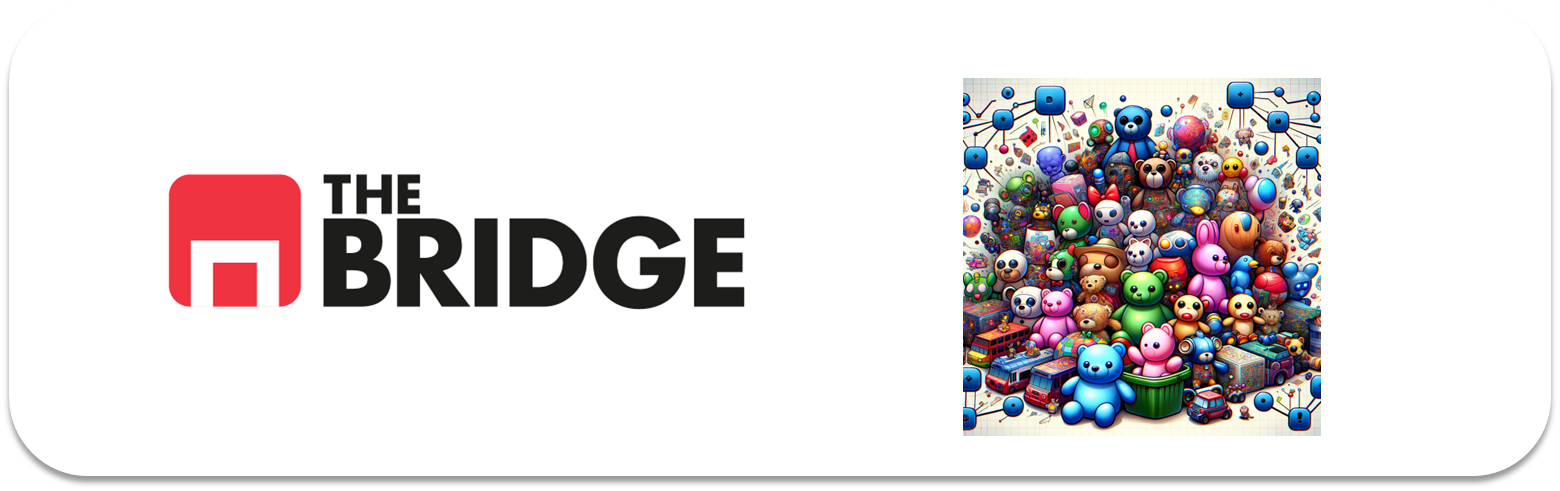

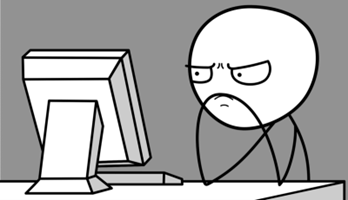

## PRACTICA OBLIGATORIA: DBSCAN y CLUSTERING JERARQUICO

* La práctica obligatoria de esta unidad consiste en un ejercicio de modelado no supervisado aplicado a clustering jerárquico y no jerárquico. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo. 
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso. 

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook

In [1]:
# Common imports
import numpy as np
import seaborn as sns
import pandas as pd

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

### Parte I. Modelado

#### Descripción del problema.

En una planta de experimentación con nuevas bebidas energéticas están trabajando con diferentes mezclas de componentes para obtener posibles variedades de su producto estrella "NonstopU". El problema es que la fabricación de cada "prototipo" conlleva demasiado tiempo y las pruebas de sabores y de propiedades "non-stop" antisueño y antifatiga son costosas.  

En ese sentido quieren construir algún sistema de segmentación previa de mezclas sin probarlas solo indicando las cantidades de cada componente de la bebida. Tienen datos pero desgraciadamente de mezclas anteriores con diferentes medidas pero que por temas presupuestarios y de prioridad no se hicieron test con usuarios y potenciales clientes, es decir no tienen un target de capacidad antifatiga o de preferncia del usuario que puedas servirles para construir un clasificador clásico como han hecho otras veces.  

Han acudido a vosotros con la necesidad de encontrar ese segmentador de posibles bebidas y con los datos de las mezclas no probadas anteriores por ver si vostros podéis ayudarles a encontrar algún tipo de segmentación que luego ello se encargarían de interpretar. No es requisito obligatorio pero les gustaría también poder establecer algún tipo de relación entre las segmentaciones (tipo cuales segmentos se "parecerían" más entre sí)

NOTA ORIENTATIVA: Los químicos no esperan que haya menos de 3 segmentos ni más de 5.  
NOTA OPERATIVA: El dataset con los datos que nos han dado los químicos está en "./data/empowering_drinks.csv"

**Se pide**: Construir al menos dos algoritmos de clustering (DBSCAN debe ser uno de ellos y el otro debería estar claro cual deberíamos usar dado el enunciado). Compararlos brevemente aunque sea meramente especulativo (¿Por qué es espculativo?)

**Se recomienda**: Visualizar las features dos a dos para escoger las mejores, no necesariamente hay que usar todas, ni tampoco quedarse en dos. Probar diferentes hiperparámetros en función de la nota orientativa y explicar porqué se han escogido los que finalmente se hayan escogido. 

Recuerda que el proceso es similar a lo que vimos en el otro tipo de aprendizaje:
1. Entender el problema
2. Cargar datos, visualizar.
3. MiniEDA: Selección de features
4. Tratamiento de Features.
5. Selección de modelos, selección de hiperparámetros
6. Entrenamiento, visualización de resultados.
7. Discusión de los mismos


1. Entender el problema


[MS] Está claro que no tenemos un tarjet y es por ello por lo que nuestro modelo será no supervisado.
Respecto al primer método, nos lo indican claramente en el enunciado, **DBSCAN**.
El segundo nos lo dejan a nuestra elección y, dado que  
*...les gustaría también poder establecer algún tipo de relación entre las segmentaciones (tipo cuales segmentos se "parecerían" más entre sí)...*  
Me decanto por la uilización de un **clústering jerárquico** para ese segundo método de evaluación.

2. Cargar datos, visualizar.


In [2]:
df = pd.read_csv("./data/empowering_drinks.csv", sep = "|", encoding = "utf-8")
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153 entries, 0 to 152
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Azúcares               153 non-null    float64
 1   Vitamínas del grupo B  153 non-null    float64
 2   Cafeína                153 non-null    float64
 3   Ácido Cítrico          153 non-null    float64
 4   Taurina                153 non-null    float64
dtypes: float64(5)
memory usage: 6.1 KB


,Azúcares,Vitamínas del grupo B,Cafeína,Ácido Cítrico,Taurina
0,1.518613,0.232053,1.034819,1.013009,0.251717
1,0.246290,-0.827996,0.733629,0.965242,-0.293321
2,0.196879,1.109334,1.215533,1.395148,0.269020
3,1.691550,0.487926,1.466525,2.334574,1.186068
4,0.295700,1.840403,0.663351,-0.037874,-0.319276


3. MiniEDA: Selección de features


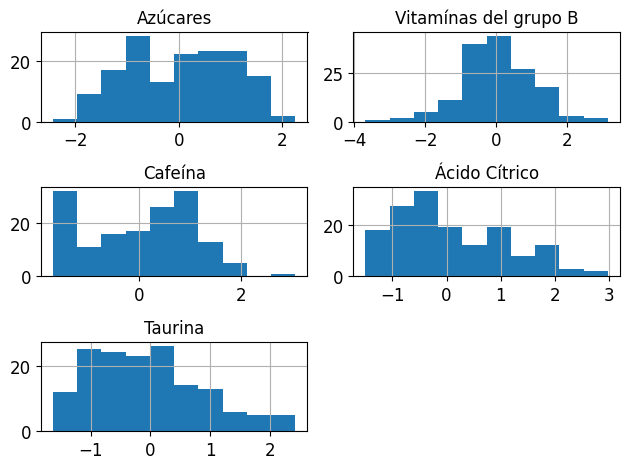

In [3]:
df.hist()
plt.tight_layout()

In [4]:
# Observamos que hay valores negativos y no tendrían sentido en este contexto
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Azúcares,153.0,0.019231,1.026182,-2.434235,-0.816038,0.061000,0.876275,2.259772
Vitamínas del grupo B,153.0,0.037273,0.995984,-3.679162,-0.499016,-0.023821,0.707247,3.156325
Cafeína,153.0,0.041057,1.040928,-1.695971,-1.043392,0.211566,0.894264,3.062832
Ácido Cítrico,153.0,0.080022,1.009450,-1.493188,-0.738463,-0.165254,0.917474,2.971473
Taurina,153.0,-0.044088,0.934399,-1.634288,-0.799428,-0.154899,0.493956,2.431870


4. Tratamiento de Features.


Dado que:  

- Hay valores negativos,  
- Hay outliers (por ejemplo, Vitamina B tiene un mínimo de -3.67 y un máximo de 3.15),  
- Y quiero aplicar clustering jerárquico (basado en distancias),  

La mejor opción es utilizar un *RobustScaler*

Datos escalados con RobustScaler:


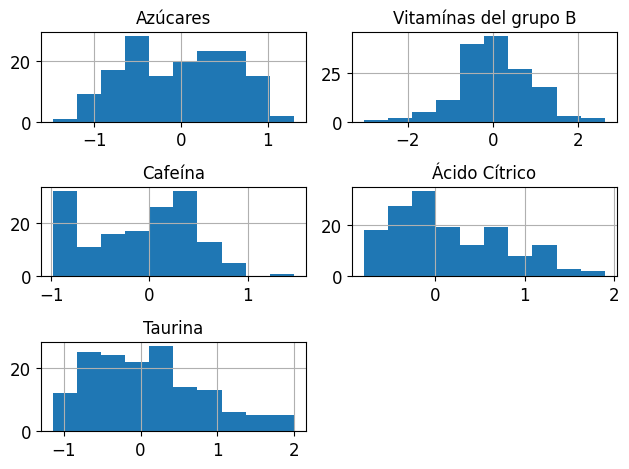

In [5]:
import pandas as pd
from sklearn.preprocessing import RobustScaler

# Aplicamos RobustScaler
scaler = RobustScaler()
scaled_data = scaler.fit_transform(df)

# Convertimos a DataFrame para visualizar
df_scaled = pd.DataFrame(scaled_data, columns=df.columns)

print("Datos escalados con RobustScaler:")
df_scaled.describe().T
df_scaled.hist()
plt.tight_layout()

Datos escalados con MinMaxScaler:
(5, 2)


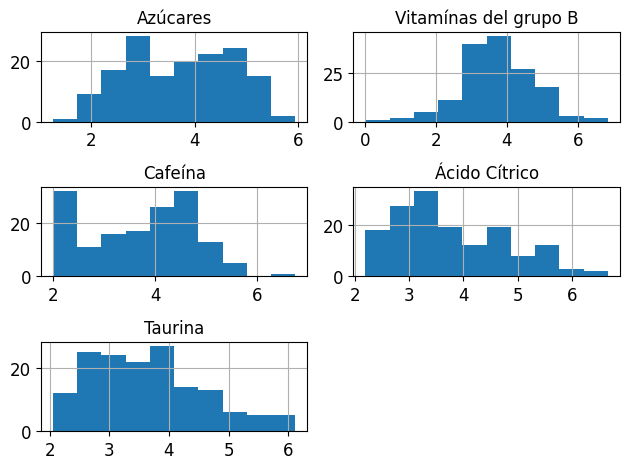

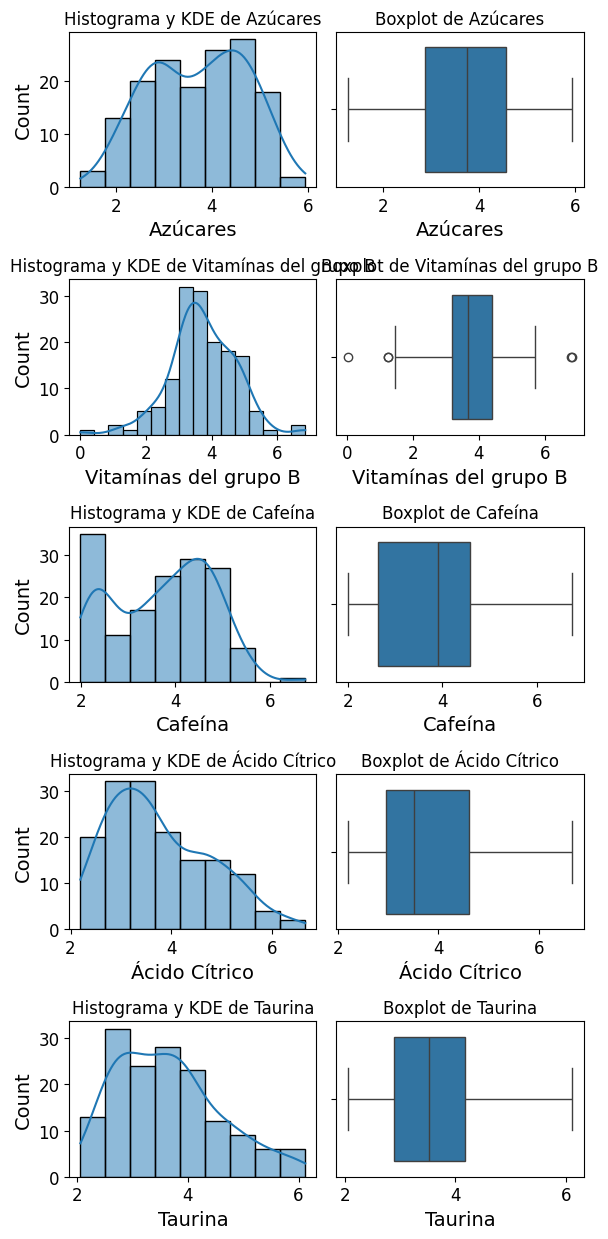

<Figure size 640x480 with 0 Axes>

In [6]:
# Aplicamos una transformación personalizada MinMaxScaler que garantice valores positivos

def transform_positive(df):
    min_val = df.min().min()
    margin = 0.01  # Pequeño margen para asegurar positividad
    df_transformed = df + abs(min_val) + margin
    return df_transformed

# Aplicar la transformación
df_trans = transform_positive(df)

print("Datos escalados con MinMaxScaler:")
df_trans.describe().T
df_trans.hist()
plt.tight_layout()

from bootcampviztools import plot_categorical_numerical_relationship, plot_combined_graphs, \
    pinta_distribucion_categoricas, plot_grouped_boxplots, plot_categorical_relationship_fin, plot_grouped_histograms

columns = list(df_trans.columns)
plot_combined_graphs(df_trans, columns)
plt.tight_layout()

5. Selección de modelos, selección de hiperparámetros


Como ya indicamos, vamos a utilizar un modelo de *Clústering jerárquico* pues estamos interesados en conocer la relación entre nuestras variables numéricas, no sólo su agrupación pues asñi nos lo han indicado desde negocio. Vamosa ver las distribuciones dos a dos para entender mejor las posibles relaciones.

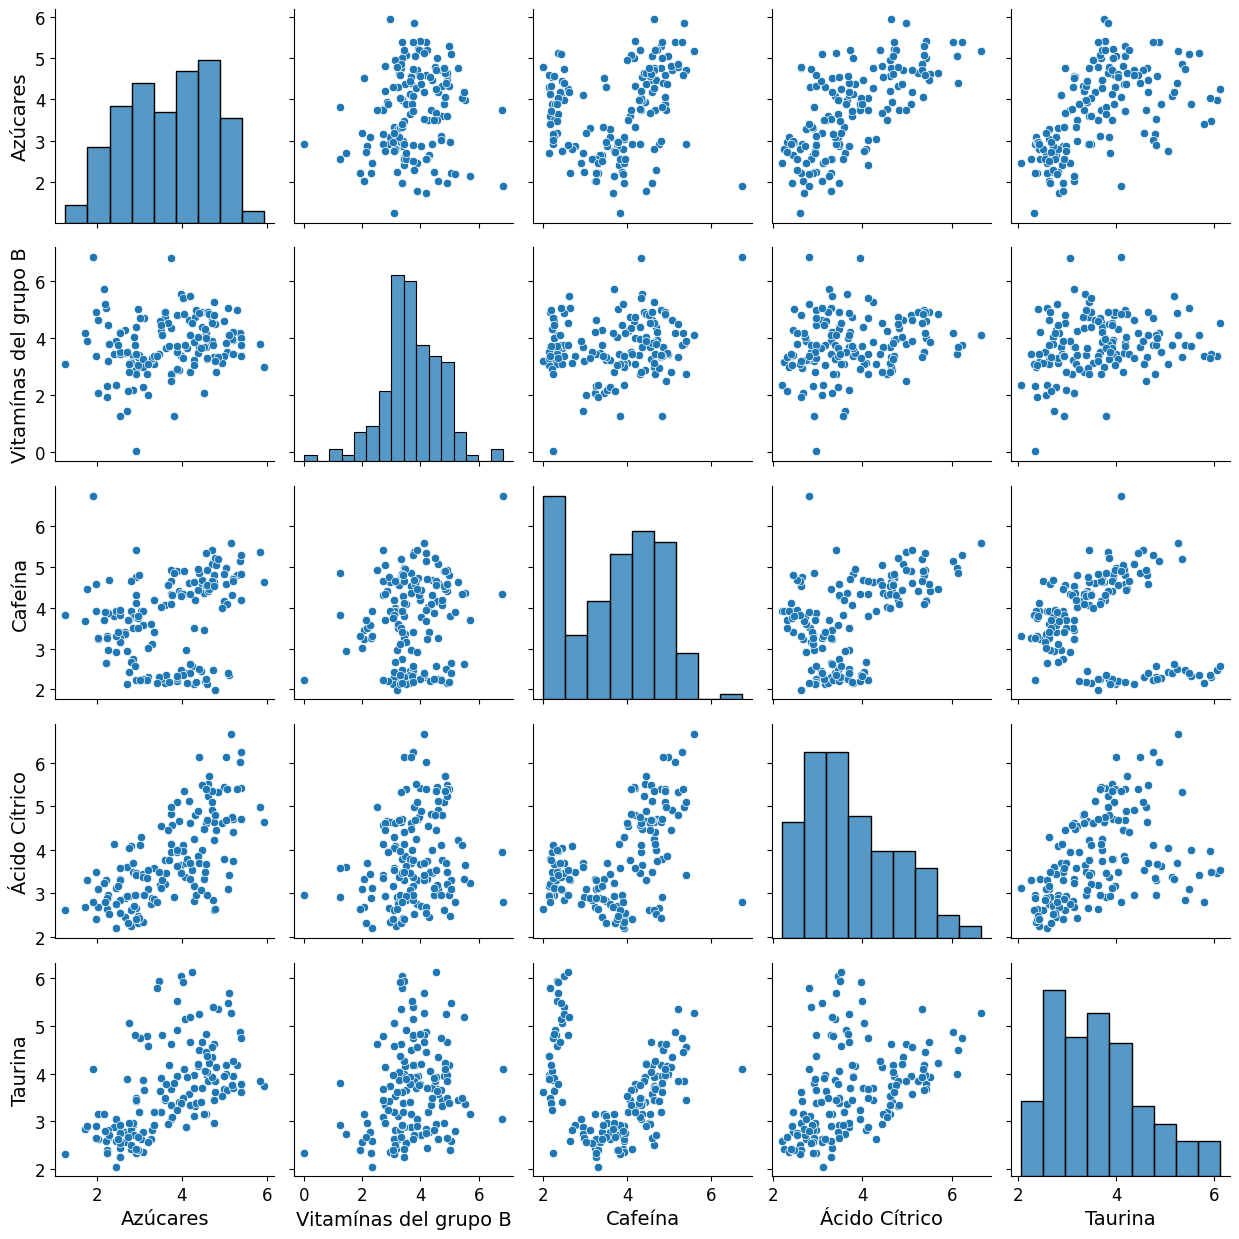

In [7]:
sns.pairplot(df_trans)
plt.tight_layout()

Nos centramos en dos features, *cafeína y taurina*, que es dónde más fácilmente observamos diferentes clústers.
También podríamos sleccionar otro par de feauttres como cafeína y axzúcares pero vamos a centrrar el ejercicio en las dos primeras.  
Utilizaremos un clústering jerárquico con dendrogramas y nuestros hiperparámetros seran *ward y euclidean*

<Axes: xlabel='Cafeína', ylabel='Taurina'>

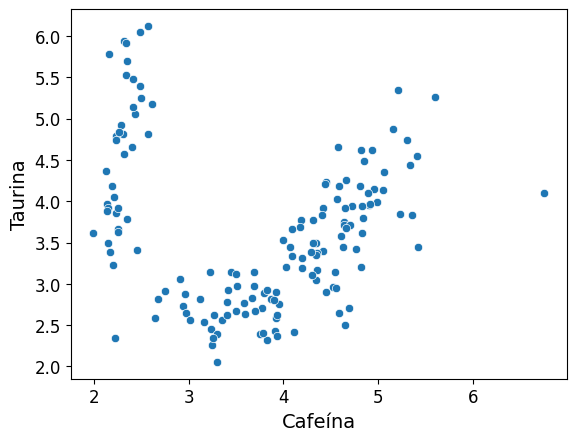

In [8]:
sns.scatterplot(x=df_trans['Cafeína'],
                y=df_trans['Taurina'])

6. Entrenamiento, visualización de resultados.

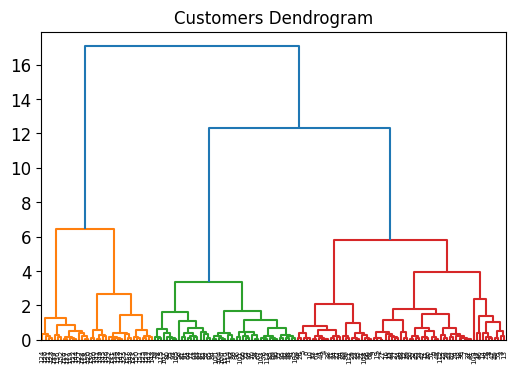

In [9]:
import scipy.cluster.hierarchy as shc
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
plt.title("Customers Dendrogram")

selected_data = df_trans[['Cafeína', 'Taurina']]
clusters = shc.linkage(selected_data, 
            method='ward', # Este hiperparámetro y el siguiente tienen que ver con la distancia entre clústeres y los veremos un poco más adelante
            metric="euclidean")
shc.dendrogram(Z=clusters)
plt.show()


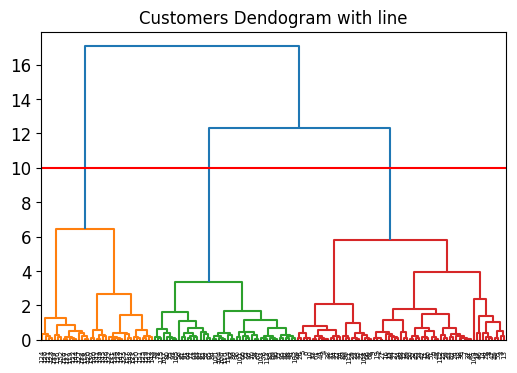

In [10]:
plt.figure(figsize=(6, 4))
plt.title("Customers Dendogram with line")
clusters = shc.linkage(selected_data, 
            method='ward', 
            metric="euclidean")
shc.dendrogram(clusters)
plt.axhline(y = 10, color = 'r', linestyle = '-')

El dendrograma solo nos sirve como referencia para elegir el número de clusters.  
Puede desviarse fácilmente de ese número y está completamente influenciado por el tipo de enlace y métricas de distancia.  
Al realizar un análisis detallado de clusters, se recomienda observar dendrogramas con diferentes enlaces y métricas, y observar los resultados generados con las primeras tres líneas en las cuales los clusters tienen la mayor distancia entre ellos.  
En nuestro caso vamos a seleccionar 3 clústers

In [11]:
from sklearn.cluster import AgglomerativeClustering

clustering_model = AgglomerativeClustering(n_clusters=3, metric='euclidean', linkage='ward')
clustering_model.fit(selected_data)
clustering_model.labels_

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 1, 2, 1, 1, 2, 2, 2,
       1, 2, 1, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1,
       2, 1, 1, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

Text(0.5, 1.0, 'Labeled Customer Data')

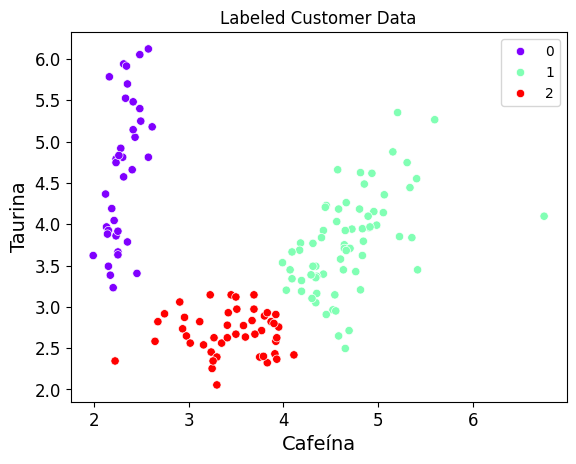

In [12]:
data_labels = clustering_model.labels_
sns.scatterplot(x='Cafeína', 
                y='Taurina', 
                data=selected_data, 
                hue=data_labels, palette = "rainbow").set_title('Labeled Customer Data')

También podríamos comprobar el modelo para azúcares y cafeína

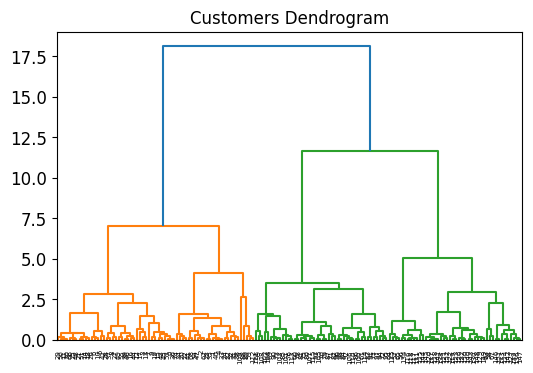

In [13]:
plt.figure(figsize=(6, 4))
plt.title("Customers Dendrogram")

selected_data = df_trans[['Azúcares', 'Cafeína']]
clusters = shc.linkage(selected_data, 
            method='ward', # Este hiperparámetro y el siguiente tienen que ver con la distancia entre clústeres y los veremos un poco más adelante
            metric="euclidean")
shc.dendrogram(Z=clusters)
plt.show()

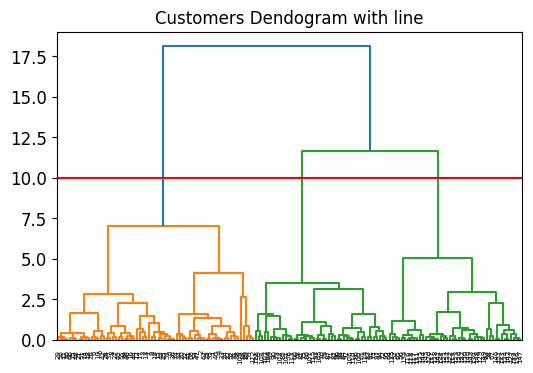

In [14]:
plt.figure(figsize=(6, 4))
plt.title("Customers Dendogram with line")
clusters = shc.linkage(selected_data, 
            method='ward', 
            metric="euclidean")
shc.dendrogram(clusters)
plt.axhline(y = 10, color = 'r', linestyle = '-')

Text(0.5, 1.0, 'Labeled Customer Data')

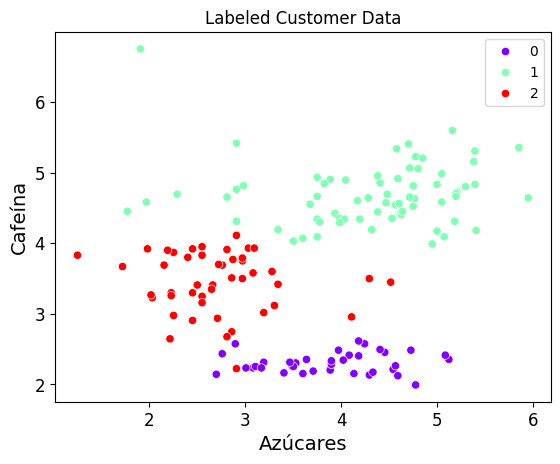

In [15]:
from sklearn.cluster import AgglomerativeClustering
clustering_model = AgglomerativeClustering(n_clusters=3, metric='euclidean', linkage='ward')
clustering_model.fit(selected_data)
clustering_model.labels_
sns.scatterplot(x='Azúcares', 
                y='Cafeína', 
                data=selected_data, 
                hue=data_labels, palette = "rainbow").set_title('Labeled Customer Data')

Seleccionamos también ácido cítrico  azúcares para completar nuestro análisis.

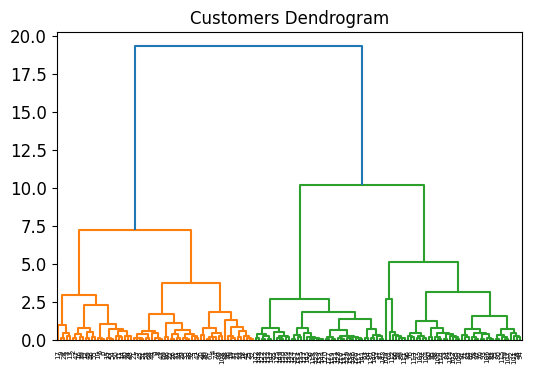

In [16]:
plt.figure(figsize=(6, 4))
plt.title("Customers Dendrogram")

selected_data = df_trans[['Ácido Cítrico', 'Cafeína']]
clusters = shc.linkage(selected_data, 
            method='ward', # Este hiperparámetro y el siguiente tienen que ver con la distancia entre clústeres y los veremos un poco más adelante
            metric="euclidean")
shc.dendrogram(Z=clusters)
plt.show()

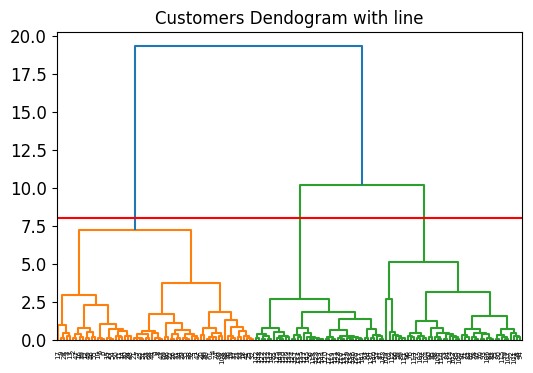

In [17]:
plt.figure(figsize=(6, 4))
plt.title("Customers Dendogram with line")
clusters = shc.linkage(selected_data, 
            method='ward', 
            metric="euclidean")
shc.dendrogram(clusters)
plt.axhline(y = 8, color = 'r', linestyle = '-')

Text(0.5, 1.0, 'Labeled Customer Data')

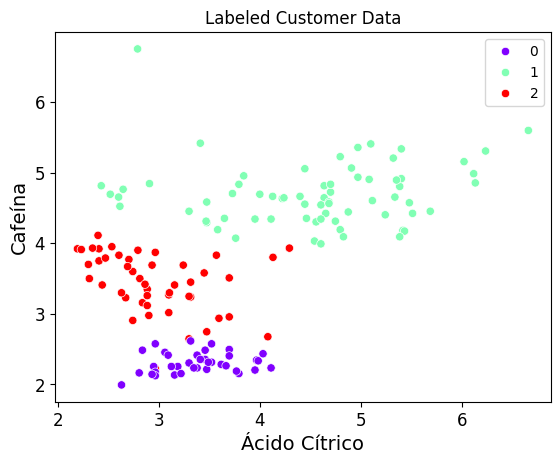

In [18]:
from sklearn.cluster import AgglomerativeClustering
clustering_model = AgglomerativeClustering(n_clusters=3, metric='euclidean', linkage='ward')
clustering_model.fit(selected_data)
clustering_model.labels_
sns.scatterplot(x='Ácido Cítrico', 
                y='Cafeína', 
                data=selected_data, 
                hue=data_labels, palette = "rainbow").set_title('Labeled Customer Data')

7. Discusión de los mismos

Hemos elegido tres relaciones en las que claramente podíamos ver una clústerización con el menor número de clústers posibles.  
El resto de ingredientes salvo Ácido Cítrico y Azúcares que representa una realación en torno a su diagonal principal, no podemos identificar claramente sus arupamientos.
Quizás podríamos haber reducido la distancia y encontrar mayor número de clústers pero no creo que nos ofreciese mejoras en el resultado.
Incluso cuando hemos comparado Ácido Cítrico con Cafeína la distancia entre 3 y 4 clústers era menor que el resto de bivariantes consideradas.

### Parte II. Nuevos experimentos

Los químicos están muy esperanzados con los modelos que les habéis mostrado y os pasan una lista de nuevos experimentos para que los clasifiquéis. Emplea uno de los modelos construidos, el que te resulte más sencillo, para segmentar los nuevos experimentos que puedes encontrar en "./data/new_experiments.csv"

In [19]:
df_new = pd.read_csv("./data/new_experiments.csv", sep = "|", encoding = "utf-8")
df_new.info()
df_new.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6 entries, 0 to 5
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Azúcares               6 non-null      float64
 1   Vitamínas del grupo B  6 non-null      float64
 2   Cafeína                6 non-null      float64
 3   Ácido Cítrico          6 non-null      float64
 4   Taurina                6 non-null      float64
dtypes: float64(5)
memory usage: 372.0 bytes


,Azúcares,Vitamínas del grupo B,Cafeína,Ácido Cítrico,Taurina
0,1.481555,0.305159,1.366128,2.239039,0.731870
1,0.616869,0.890014,0.583034,0.312420,-0.665332
2,-1.680724,0.341713,-0.340615,-0.213021,-0.976782
3,-0.284874,-1.412851,-0.782361,-1.193845,-0.717240
4,-0.927212,0.634140,-1.565455,-0.085641,-0.522583


Sólo tenemos un modelo con 6 ensayos. Magia... no podemos hacer.  
Tenemos muchos datos faltantes como veremos a continuación. 

In [20]:
# Observamos que hay valores negativos y no tendrían sentido en este contexto
df_new.describe().T

,count,mean,std,min,25%,50%,75%,max
Azúcares,6.0,0.028059,1.205271,-1.680724,-0.766628,0.165997,0.876275,1.481555
Vitamínas del grupo B,6.0,0.085839,0.826463,-1.412851,-0.106066,0.323436,0.561033,0.890014
Cafeína,6.0,-0.348982,1.139233,-1.565455,-1.211557,-0.561488,0.352122,1.366128
Ácido Cítrico,6.0,0.106490,1.157346,-1.193845,-0.368265,-0.149331,0.212905,2.239039
Taurina,6.0,-0.032337,1.143657,-0.976782,-0.704263,-0.593957,0.418256,1.956043


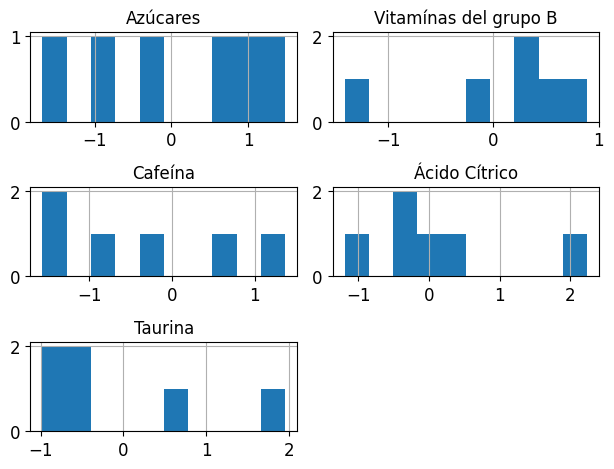

In [21]:
df_new.hist()
plt.tight_layout()

Datos escalados con MinMaxScaler:
(5, 2)


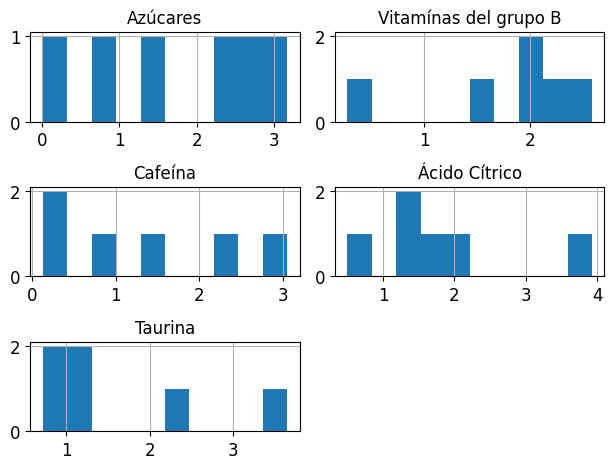

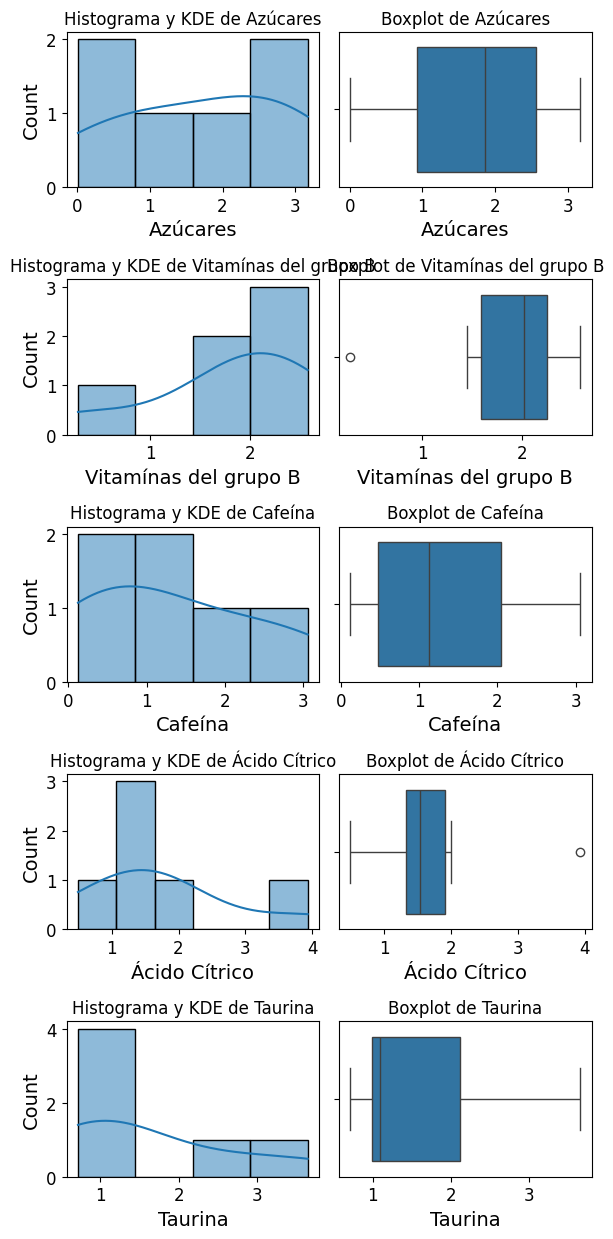

<Figure size 640x480 with 0 Axes>

In [24]:
# Aplicamos una transformación personalizada MinMaxScaler que garantice valores positivos

def transform_positive(df):
    min_val = df.min().min()
    margin = 0.01  # Pequeño margen para asegurar positividad
    df_transformed = df + abs(min_val) + margin
    return df_transformed

# Aplicar la transformación
df_trans2 = transform_positive(df_new)

print("Datos escalados con MinMaxScaler:")
df_trans2.describe().T
df_trans2.hist()
plt.tight_layout()

from bootcampviztools import plot_categorical_numerical_relationship, plot_combined_graphs, \
    pinta_distribucion_categoricas, plot_grouped_boxplots, plot_categorical_relationship_fin, plot_grouped_histograms

columns = list(df_trans2.columns)
plot_combined_graphs(df_trans2, columns)
plt.tight_layout()

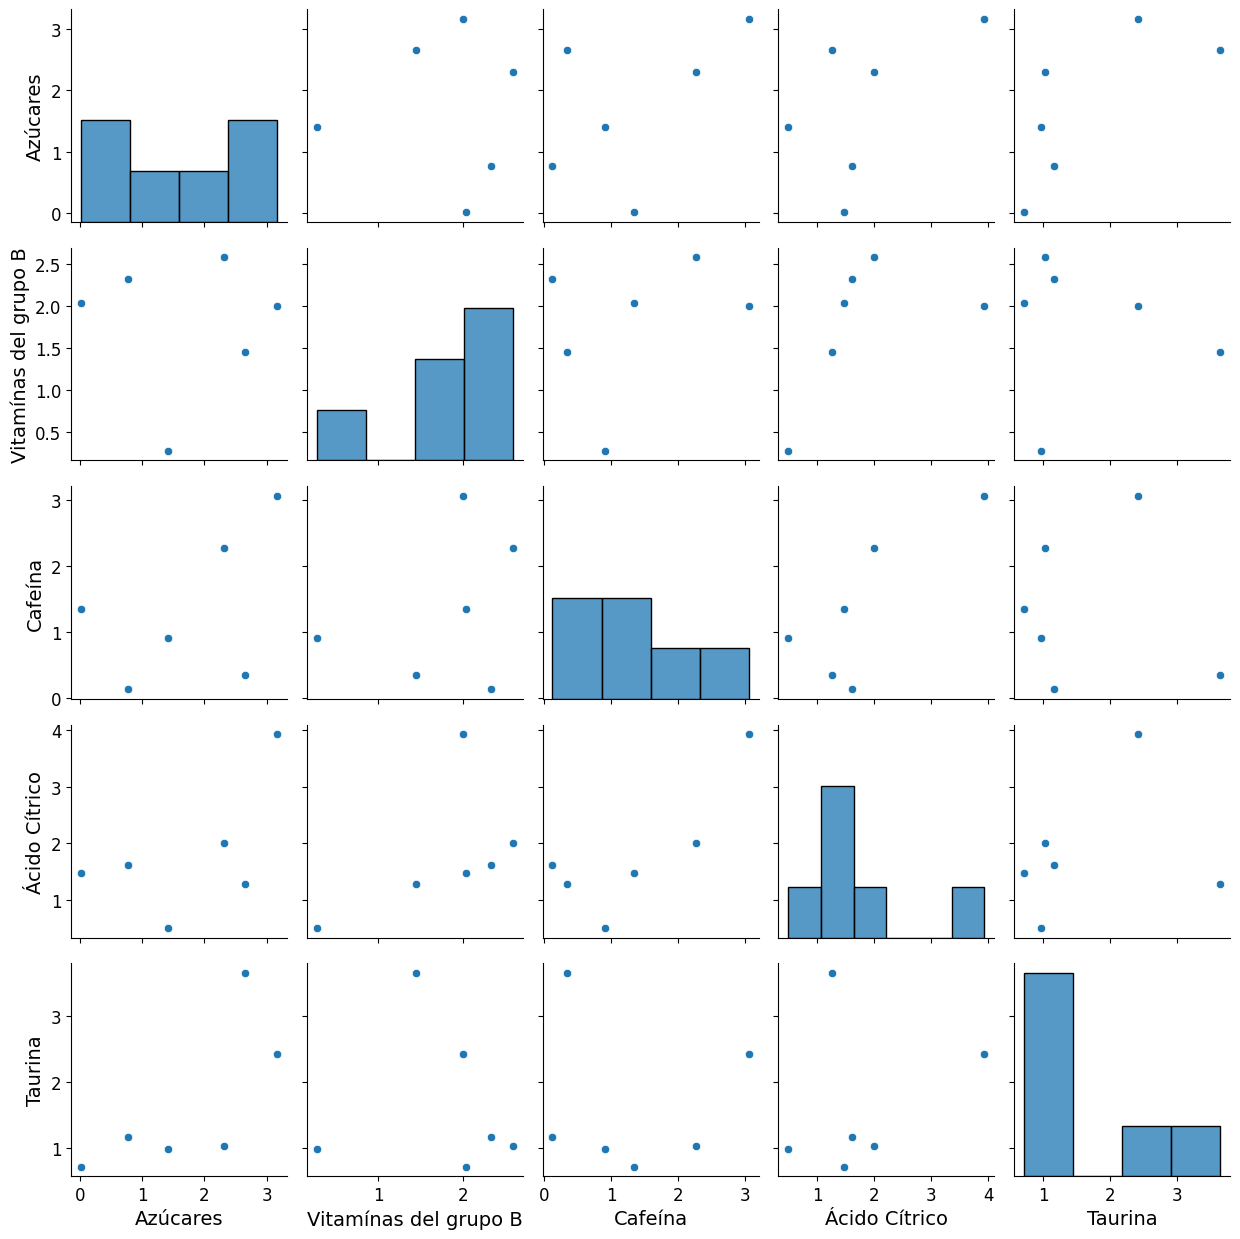

In [25]:
sns.pairplot(df_trans2)
plt.tight_layout()

Con el modelo planteado anteriormente y con esta discretización de datos no es posible aventurarse a sacar ninguna conclusión.  
**Sería una temeridad por nuestra parte. Necesitamos un mínimo de datos para poder entender el modelo y sacar conclusiones.**

### Parte III. EXTRA (Voluntario): 6 meses después...

La unidad de experimentación recibió un presupuesto adicional gracias a los modelos que les proporcionastes e hizo pruebas con cliente y obtuvo resultados como para clasificar cada bebida en terminos de "energización" en tres niveles (1, media; 2, media-alta, 3, alta). El resultado de los mismos está en el fichero adecuado en el directorio data y alineado con los experimentos iniciales y al final con los nuevos experimentos de la parte anterior.

Evalua la segmentación de los modelos creados en la primera parte.